In [1]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt

In [2]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False) -> None:
        self.mem_size = max_size
        self.mem_cntr = 0
        self.input_shape = input_shape
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - int(done)
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]
        return states, actions, rewards, states_, dones

In [3]:
def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(fc1_dims, input_shape=(input_dims,), activation='relu'),
        tf.keras.layers.Dense(fc2_dims, activation='relu'),
        tf.keras.layers.Dense(n_actions, activation=None)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError())
    model.summary()
    return model

In [4]:
class Agent(object):
    def __init__(
            self, alpha, gamma, n_actions, epsilon, batch_size, input_dims, epsilon_dec=0.996, epsilon_end=0.01,
            mem_size=1000000, fname='dqn_model.h5') -> None:
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions, discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state, verbose=0)
            action = np.argmax(actions)
        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)
            q_next = self.q_eval.predict(new_state, verbose=0)
            q_eval = self.q_eval.predict(state, verbose=0)
            q_target = q_eval.copy()
            batch_index = np.arange(self.batch_size, dtype=np.int32)
            q_target[batch_index, action_indices] = reward + self.gamma * np.max(q_next, axis=1) * done
            _ = self.q_eval.fit(state, q_target, verbose=0)
            self.epsilon = self.epsilon * self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon_min

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = tf.keras.models.load_model(self.model_file)

In [5]:
env = gym.make('LunarLander-v2', max_episode_steps=1000)
input_dims = env.observation_space.shape[0]
n_actions = env.action_space.n
print("Input dimensions:", input_dims, "\nNumber of actions:", n_actions)

Input dimensions: 8 
Number of actions: 4


In [6]:
n_games = 10
agent = Agent(gamma=0.99, epsilon=1.0, alpha=0.0005, input_dims=input_dims,
              n_actions=n_actions, mem_size=1_000_000, batch_size=64, epsilon_end=0.01)
scores = []
eps_history = []

for i in range(n_games):
    done = False
    truncated = False
    score = 0
    observation, _ = env.reset()

    while not done and not truncated:
        action = agent.choose_action(observation)
        observation_, reward, done, truncated, info = env.step(action)
        score += reward
        agent.remember(observation, action, reward, observation_, done)
        observation = observation_
        agent.learn()

    eps_history.append(agent.epsilon)
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    print(f'episode: {i}, score: {score}, average score: {avg_score}, epsilon: {agent.epsilon}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 69124 (270.02 KB)
Trainable params: 69124 (270.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


d:\Projects\repo\beratcmn\tensorflow-cartpole\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 0, score: -104.3874150244512, average score: -104.3874150244512, epsilon: 0.992016
episode: 1, score: -348.97149876302365, average score: -226.67945689373744, epsilon: 0.7198893534118974
episode: 2, score: 25.785063175224423, average score: -142.52461687075015, epsilon: 0.45041033411706516
episode: 3, score: -396.7931497314272, average score: -206.09175008591941, epsilon: 0.24590561657294566
episode: 4, score: -110.89936862952935, average score: -187.0532737946414, epsilon: 0.17988578484188741
episode: 5, score: -367.6084040557255, average score: -217.14579550482208, epsilon: 0.12341690671072149
episode: 6, score: -263.8826008528546, average score: -223.8224819831124, epsilon: 0.08233184314276246
episode: 7, score: -133.57688018533133, average score: -212.5417817583898, epsilon: 0.05950784872013358
episode: 8, score: -187.35556141652515, average score: -209.74331283151594, epsilon: 0.03121244114904799
episode: 9, score: -59.69601519867929, average score: -194.7385830682323, ep

In [55]:
print(eps_history)
print(scores)

[0.992016, 0.7198893534118974, 0.45041033411706516, 0.24590561657294566, 0.17988578484188741, 0.12341690671072149, 0.08233184314276246, 0.05950784872013358, 0.03121244114904799, 0.018537097387797213]
[-104.3874150244512, -348.97149876302365, 25.785063175224423, -396.7931497314272, -110.89936862952935, -367.6084040557255, -263.8826008528546, -133.57688018533133, -187.35556141652515, -59.69601519867929]


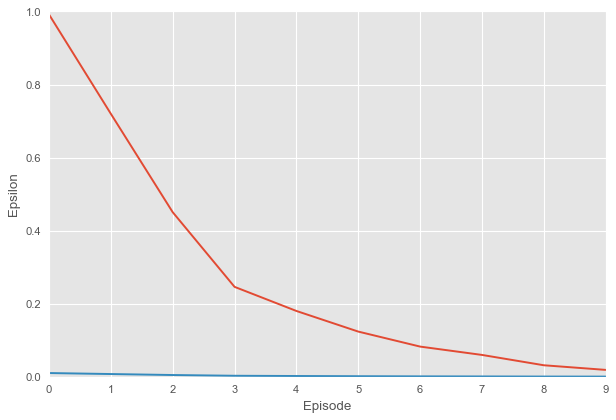

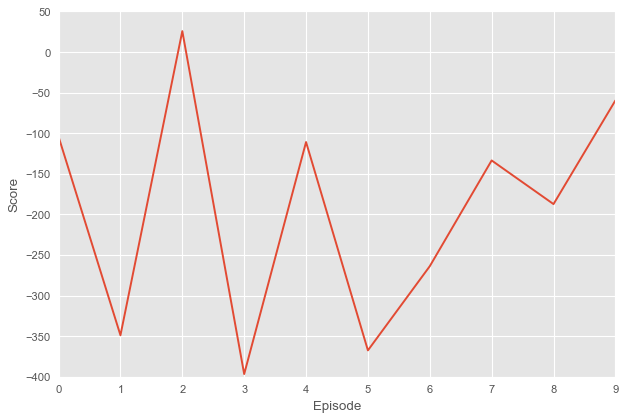

In [53]:
plt.style.use('ggplot')

# plot a graph for epsilon
plt.plot(eps_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

# plot a graph for scores
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()